In [ ]:
# importing packages
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# font size
sns.set_style("white", rc={"font_scale": 1.5})

# loforest and locart functions
from CSI.loforest import ConformalLoforest
from CSI.scores import LambdaScore

from clover import Scores
from clover import LocartSplit

from copy import deepcopy
from tqdm import tqdm

from scipy import stats
from scipy.optimize import minimize_scalar

import time
import itertools

\section{Comparing our methods for a BFF example with normal distribution}
Taking $(\mu, \sigma^2) \in \Theta = [-5,5] \times (0, 1]$ we consider a normal-inverse gamma prior over $(\mu, \sigma^2)$ given by:
\begin{align*}
\mu|\sigma^2 \sim N(0, 0.25 \sigma^2) , \\
\sigma^2 \sim IG(2 ,1) ,
\end{align*}
with the likelihood of $X$ given by:
\begin{align*}
X|\mu, \sigma^2 \sim N(\mu, \sigma^2).
\end{align*}
In this case, we obtain the $1 - \alpha$ credibility region of $\theta$ by obtaining $C_{\theta}$ such that:
\begin{align*}
\mathbb{P}(\{(\mu, \sigma^2): f(\mu, \sigma^2|x) \geq C_{\left( \mu, \sigma^2 \right)}\}) = 1 - \alpha .
\end{align*}

Now we define the main functions to simulate all samples and compute naive quantiles:

In [36]:
def sim_X(n, mu, sigma_2, rng):
    X = rng.normal(mu, np.sqrt(sigma_2), n)
    return X


def sim_lambda(B, N, mu, rng, sigma_2, l=4, a=2, beta=1):
    lambdas = np.zeros(B)
    for i in range(0, B):
        X = sim_X(N, mu, sigma_2, rng)
        lambdas[i] = compute_pdf_posterior(
            mu,
            sigma_2,
            X,
            l=l,
            a=a,
            beta=beta,
        )
    return lambdas


def sample_posterior(B, N, rng, l=4, a=2, beta=1):
    thetas = np.c_[rng.uniform(-5, 5, B), rng.uniform(0, 1, B)]
    lambdas = np.zeros(B)
    i = 0
    for mu, sigma_2 in thetas:
        X = sim_X(N, mu, sigma_2, rng)
        lambdas[i] = compute_pdf_posterior(
            mu,
            sigma_2,
            X,
            l=l,
            a=a,
            beta=beta,
        )
        i += 1
    return thetas, lambdas


def compute_pdf_posterior(mu, sigma_2, x, l=4, a=2, beta=1):
    n = x.shape[0]
    sum_squares = n * np.var(x)
    x_bar = np.mean(x)

    # posterior parameters
    mu_value = (1 / (l + n)) * (np.sum(x))
    l_value = l + n
    alpha_value = a + (n / 2)
    beta_value = (
        beta + ((1 / 2) * (sum_squares)) + ((n * l) / (l + n) * ((x_bar**2) / 2))
    )

    # pdf for mu
    f_mu = stats.norm.pdf(mu, loc=mu_value, scale=np.sqrt(sigma_2 / l_value))

    f_sigma_2 = stats.invgamma.pdf(sigma_2, a=alpha_value, scale=beta_value)

    return -(f_mu * f_sigma_2)


# naive method
def naive(
    alpha,
    rng,
    B=1000,
    N=100,
    naive_n=100,
    l=10,
    a=10,
    beta=1,
):
    n_grid = int(B / naive_n)
    mu = np.linspace(-5, 5, n_grid)
    sigma_2 = np.linspace(0.0001, 1, n_grid)
    quantiles = {}
    for mu, sigma_2 in itertools.product(mu, sigma_2):
        lambdas = sim_lambda(
            B=int(np.sqrt(naive_n)),
            N=N,
            rng=rng,
            mu=mu,
            sigma_2=sigma_2,
            l=l,
            a=a,
            beta=beta,
        )
        quantiles[(mu, sigma_2)] = np.quantile(lambdas, q=1 - alpha)
    return quantiles


# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for x in theta_grid:
        distances = np.linalg.norm(thetas_values - x, axis=1)
        idx = thetas_values[np.argmin(distances)]
        quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

Lets now compare our methods to all the others for several N:

In [41]:
def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    min_samples_leaf=300,
    K = 40,
    n_estimators = 100,
    naive_n=100,
    l=4,
    a=2,
    beta=1,
):
    # fitting and predicting naive
    naive_quantiles = naive(
        alpha=alpha,
        B=B,
        N=N,
        naive_n=naive_n,
        l=l,
        a=a,
        beta=beta,
        rng = rng,
    )

    # simulating to fit models
    model_thetas, model_lambdas = sample_posterior(B=B, N=N, rng=rng, l = l, a = a, beta = beta)

    locart_object = LocartSplit(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    locart_quantiles = locart_object.calib(
        model_thetas, model_lambdas, min_samples_leaf=100
    )

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf, K = K, n_estimators = n_estimators
    )

    # boosting quantiles
    model = HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile=1 - alpha,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
    model.fit(model_thetas, model_lambdas)

    # naive quantiles
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # locart quantiles
    idxs = locart_object.cart.apply(thetas)
    list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas)

    # boosting
    boosting_quantiles = model.predict(thetas)

    # dictionary of quantiles
    quantile_dict = {
        "naive": naive_list,
        "locart": list_locart_quantiles,
        "loforest": loforest_cutoffs,
        "boosting": boosting_quantiles,
    }

    return quantile_dict


# evaluate coverage for several N's and B = 1000
def evaluate_coverage_N(
    thetas,
    N=np.array([10, 100, 1000]),
    B=1000,
    alpha=0.05,
    n=1000,
    seed=45,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 40,
    naive_n=100,
    l=4,
    a=2,
    beta=1,
):
    N_list = []
    methods_list = []
    rng = np.random.default_rng(seed)
    k = 0
    j = 0
    for N_fixed in tqdm(N, desc="Computing coverage for each N"):
        # computing all quantiles for fixed N
        quantiles_dict = obtain_quantiles(
            thetas,
            rng=rng,
            N=N_fixed,
            B=B,
            alpha=alpha,
            min_samples_leaf=min_samples_leaf,
            naive_n=naive_n,
            K=K,
            n_estimators = n_estimators,
            l=l,
            a=a,
            beta=beta,
        )
        err_data = np.zeros((thetas.shape[0], 4))
        l = 0
        for theta in tqdm(thetas, desc="Computing coverage for each method"):
            # generating several lambdas
            lambda_stat = sim_lambda(
                    B=n,
                    N=N_fixed,
                    mu=theta[0],
                    sigma_2=theta[1],
                    rng = rng,
                    l = l,
                    a = a,
                    beta = beta,
                )

            # comparing coverage of methods
            locart_cover = np.mean(lambda_stat <= quantiles_dict["locart"][l])
            loforest_cover = np.mean(lambda_stat <= quantiles_dict["loforest"][l])
            boosting_cover = np.mean(lambda_stat <= quantiles_dict["boosting"][l])
            naive_cover = np.mean(lambda_stat <= quantiles_dict["naive"][l])

            # appending the errors
            err_locart = np.abs(locart_cover - (1 - alpha))
            err_loforest = np.abs(loforest_cover - (1 - alpha))
            err_boosting = np.abs(boosting_cover - (1 - alpha))
            err_naive = np.abs(naive_cover - (1 - alpha))

            # saving in numpy array
            err_data[l, :] = np.array(
                [err_locart, err_loforest, err_boosting, err_naive]
            )

            j += 1
            l += 1
        methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive"])
        if k == 0:
            mae_vector = np.mean(err_data, axis=0)
            std_vector = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
        else:
            mean = np.mean(err_data, axis=0)
            std = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
            mae_vector, std_vector = np.concatenate((mae_vector, mean)), np.concatenate(
                (std_vector, std)
            )
        k += 1
        N_list.extend([N_fixed] * 4)

    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "MAE": mae_vector,
            "se": std_vector,
        }
    )
    return stats_data

Testing for $B = 5000$:


In [42]:
n_out = 50
mu_s = np.linspace(-5, 5, n_out)
sigmas = np.linspace(0.0001, 1, n_out)
thetas_grid = np.c_[list(itertools.product(mu_s, sigmas))]
# printing grid size
thetas_grid.shape[0]

2500

In [43]:
coverage_data_N_5000 = evaluate_coverage_N(
    thetas_grid,
    N=np.array([10, 100, 1000]),
    B=5000,
    naive_n=100,
    min_samples_leaf=300,
    n=1000,
    seed=1250,
    K = 50,
    n_estimators = 200,
)

Computing coverage for each N:   0%|          | 0/3 [00:00<?, ?it/s]

Computing coverage for each N: 100%|██████████| 3/3 [20:15<00:00, 405.31s/it]


/tmp/ipykernel_63183/980677033.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(a.get_xticklabels(), rotation=90)


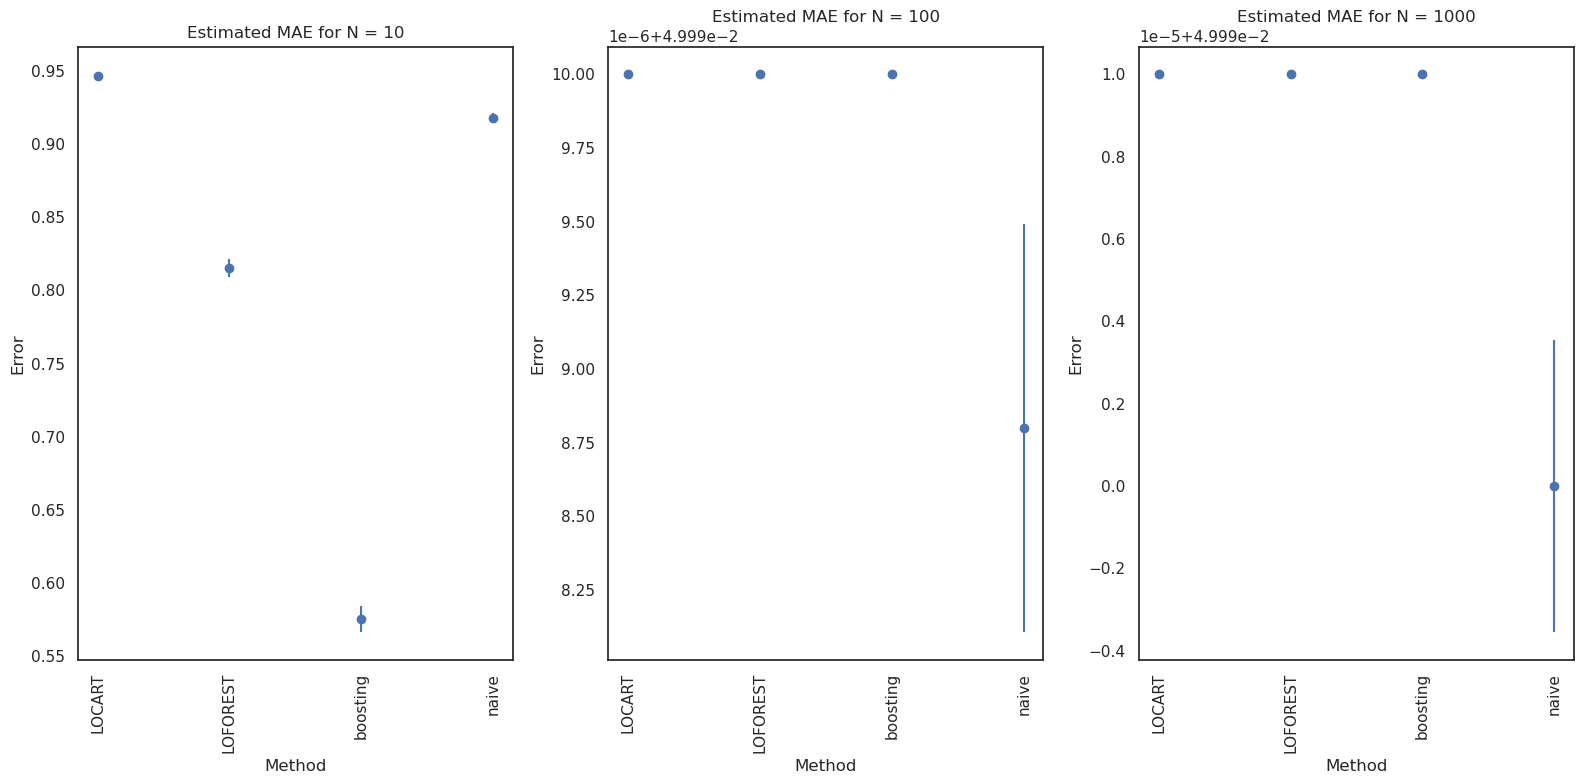

In [44]:
# | echo: false
sns.set(style="white", font_scale=1)
fig, ax = plt.subplots(ncols=3, figsize=(16, 8))
# data for first subplot
data_10 = coverage_data_N_5000.query("N == 10")
keys = data_10.iloc[:, 0].values
mae = data_10.iloc[:, 2].values
std_err = data_10.iloc[:, 3].values
ax[0].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[0].set_xlabel("Method")
ax[0].set_ylabel("Error")
ax[0].set_title("Estimated MAE for N = 10")


data_100 = coverage_data_N_5000.query("N == 100")
keys = data_100.iloc[:, 0].values
mae = data_100.iloc[:, 2].values
std_err = data_100.iloc[:, 3].values
ax[1].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[1].set_xlabel("Method")
ax[1].set_ylabel("Error")
ax[1].set_title("Estimated MAE for N = 100")


data_1000 = coverage_data_N_5000.query("N == 1000")
keys = data_1000.iloc[:, 0].values
mae = data_1000.iloc[:, 2].values
std_err = data_1000.iloc[:, 3].values
ax[2].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[2].set_xlabel("Method")
ax[2].set_ylabel("Error")
ax[2].set_title("Estimated MAE for N = 1000")

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

Computing MAE for several B's and N's

In [45]:
def compute_MAE_N(
    thetas,
    N=np.array([50, 100, 1000]),
    B=np.array([500, 1000, 5000, 10000, 15000]),
    alpha=0.05,
    n=1000,
    seed=45,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 40,
    naive_n = 100,
    l=4,
    a=5,
    beta=1,
):
    N_list = []
    mae_list = []
    se_list = []
    methods_list = []
    B_list = []
    rng = np.random.default_rng(seed)
    for N_fixed in tqdm(N, desc="Computing coverage for each N"):
        for B_fixed in B:
            # computing all quantiles for fixed N
            quantiles_dict = obtain_quantiles(
                thetas,
                N=N_fixed,
                B=B_fixed,
                alpha=alpha,
                min_samples_leaf=min_samples_leaf,
                naive_n=naive_n,
                rng = rng,
                n_estimators = n_estimators,
                K = K,
                l = l,
                a = a,
                beta = beta,
            )
            err_data = np.zeros((thetas.shape[0], 4))
            l = 0
            for theta in thetas:
                # generating several lambdas
                lambda_stat = sim_lambda(
                    B=n,
                    N=N_fixed,
                    mu=theta[0],
                    sigma_2=theta[1],
                    rng = rng,
                    l = l,
                    a = a,
                    beta = beta,
                )

                # comparing coverage of methods
                locart_cover = np.mean(lambda_stat <= quantiles_dict["locart"][l])
                loforest_cover = np.mean(lambda_stat <= quantiles_dict["loforest"][l])
                boosting_cover = np.mean(lambda_stat <= quantiles_dict["boosting"][l])
                naive_cover = np.mean(lambda_stat <= quantiles_dict["naive"][l])

                # appending the errors
                err_locart = np.abs(locart_cover - (1 - alpha))
                err_loforest = np.abs(loforest_cover - (1 - alpha))
                err_boosting = np.abs(boosting_cover - (1 - alpha))
                err_naive = np.abs(naive_cover - (1 - alpha))

                # saving in numpy array
                err_data[l, :] = np.array(
                    [err_locart, err_loforest, err_boosting, err_naive]
                )

                l += 1
            
            mae_list.extend(np.mean(err_data, axis = 0).tolist())
            se_list.extend((np.std(err_data, axis = 0)/np.sqrt(thetas.shape[0])).tolist())
            methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive"])
            N_list.extend([N_fixed] * 4)
            B_list.extend([B_fixed] * 4)

    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

In [48]:
mae_stats = compute_MAE_N(
    thetas_grid,
    N=np.array([10, 100, 1000]),
    B=np.array([1000, 5000, 10000, 15000, 20000, 30000]),
    naive_n=100,
    min_samples_leaf=300,
    n_estimators=200,
    l = 4,
    a = 4,
    beta = 1,
    K = 50,
    seed=45,
)

Computing coverage for each N: 100%|██████████| 3/3 [2:11:09<00:00, 2623.12s/it]


Plotting all results:

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> ma

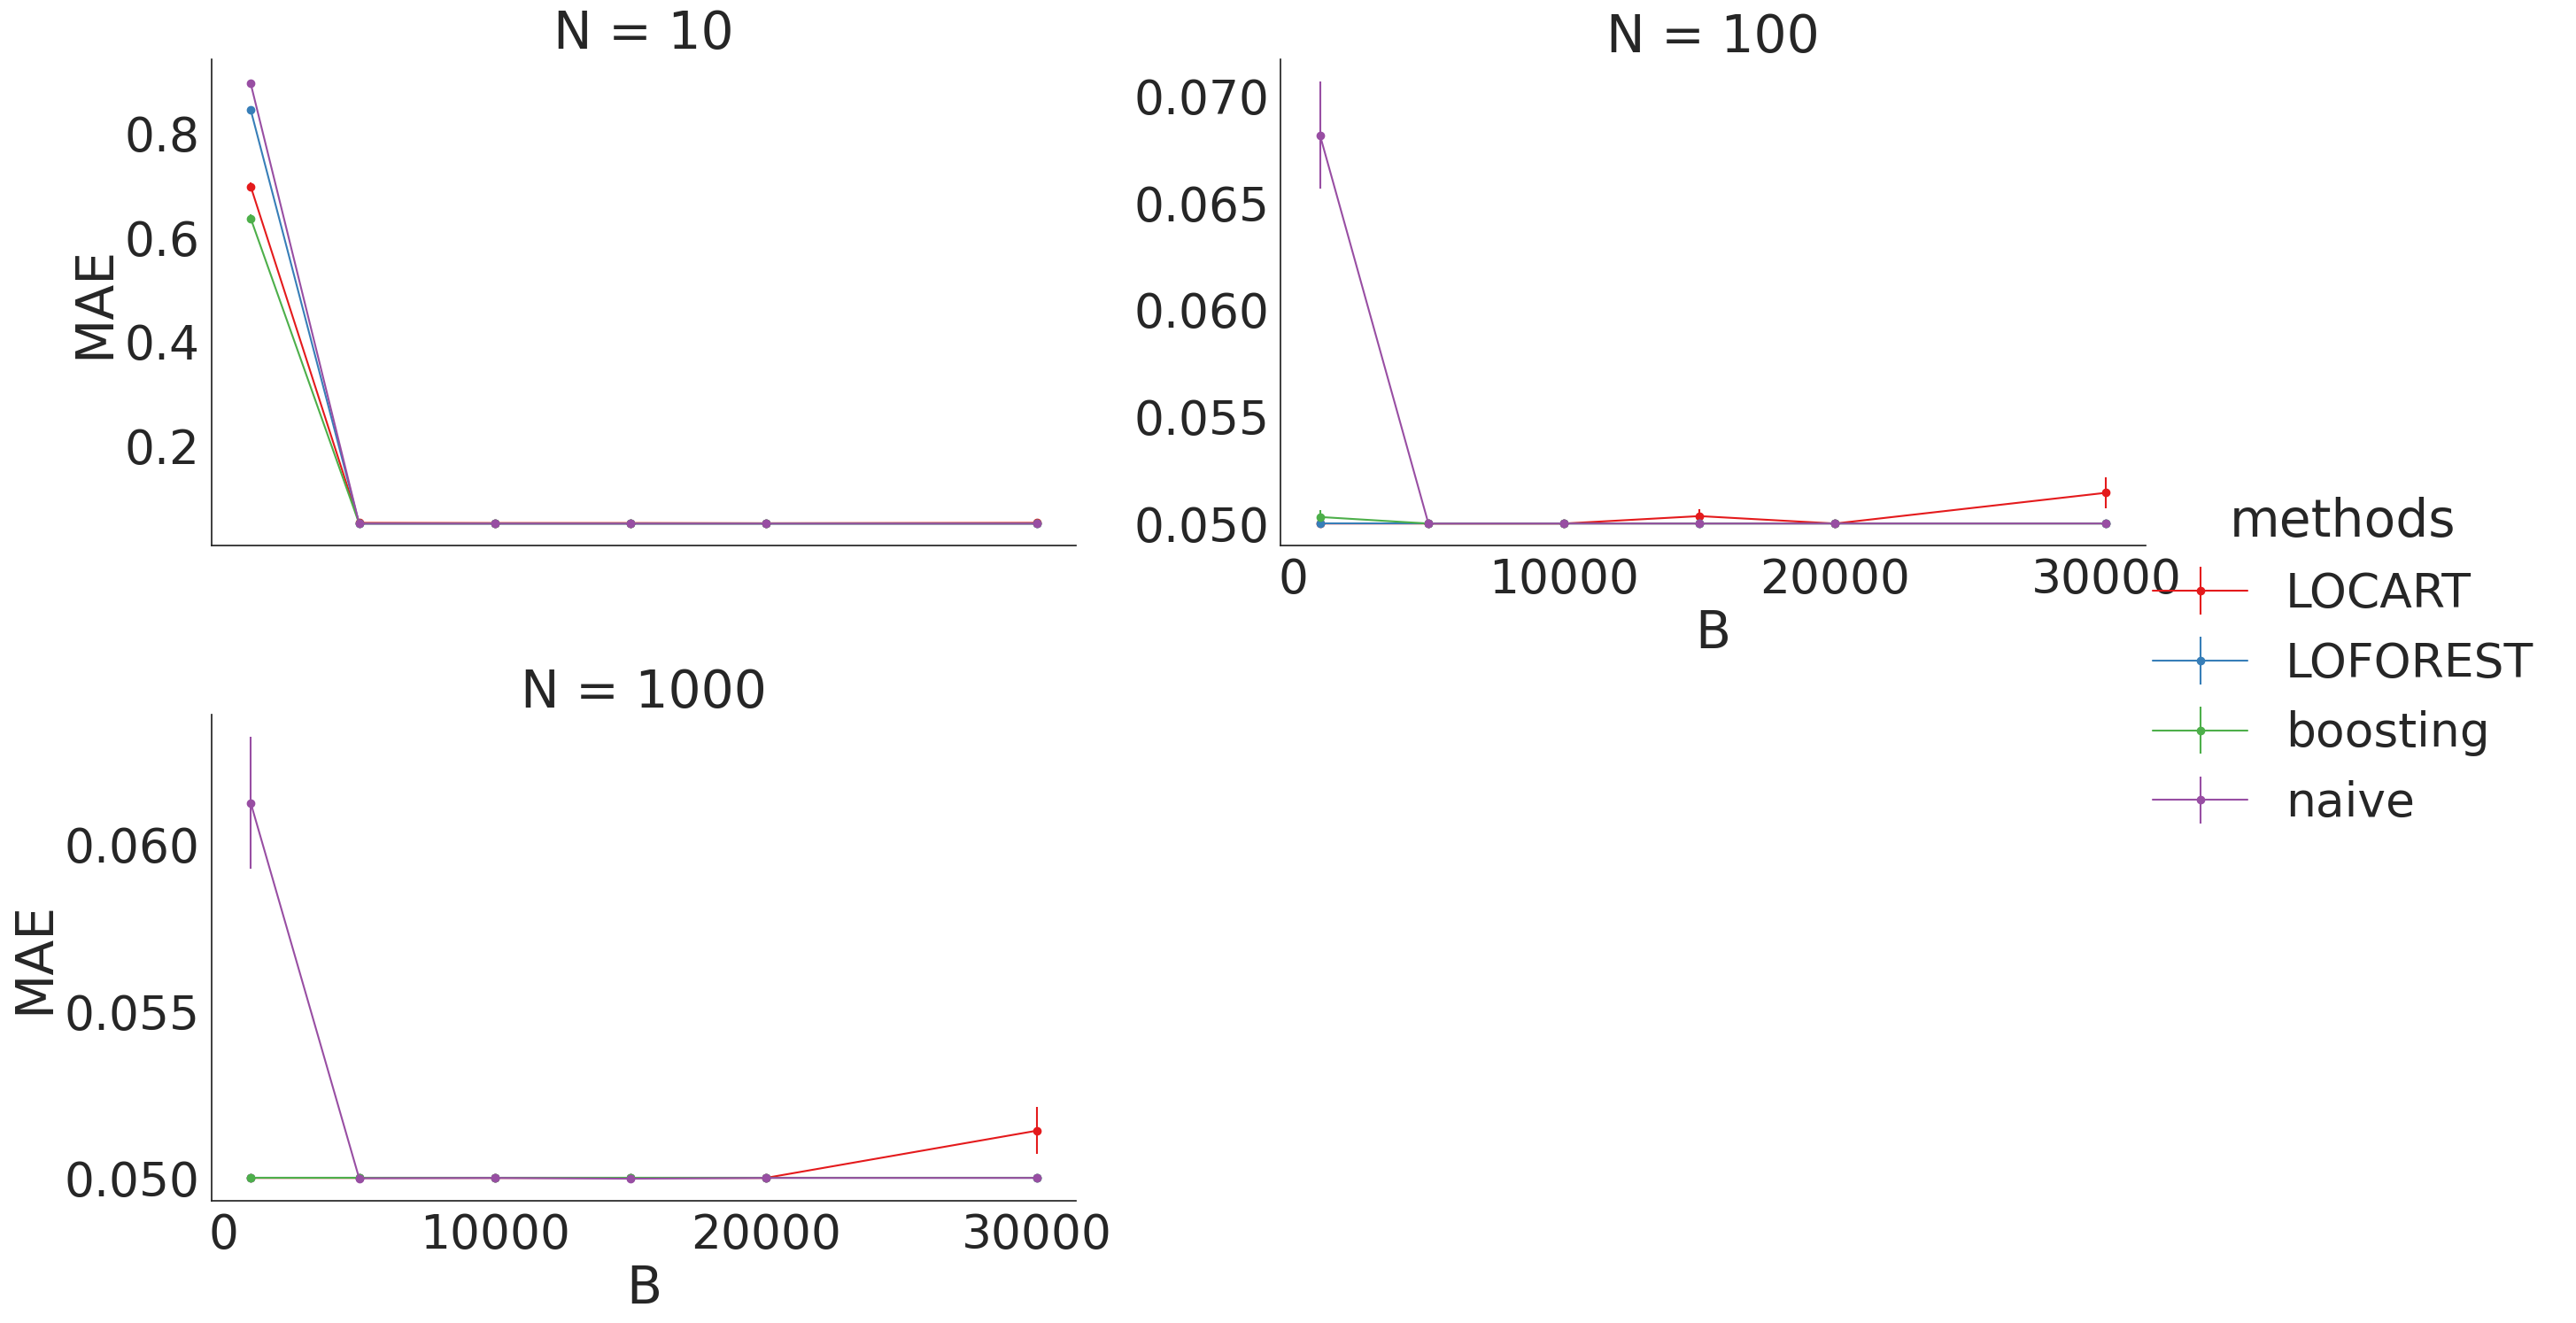

In [49]:
# Create a line plot with error bars
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    mae_stats,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    hue="methods",
    palette="Set1",
    margin_titles=True,
    sharey=False,
)
g.map(plt.errorbar, "B", "MAE", "se", marker="o", fmt="-o")
g.add_legend()

# Show the plot
plt.show()